In [1]:
import quandl

In [2]:
data = quandl.get("WIKI/AAPL")

In [6]:
data.to_csv("apple_stock.csv")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("apple_stock.csv")[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [3]:
data.set_index("Date", inplace=True)
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
1980-12-12,28.75,28.87,28.75,28.75,2093900.0
1980-12-15,27.38,27.38,27.25,27.25,785200.0
1980-12-16,25.37,25.37,25.25,25.25,472000.0
1980-12-17,25.87,26.00,25.87,25.87,385900.0
1980-12-18,26.63,26.75,26.63,26.63,327900.0


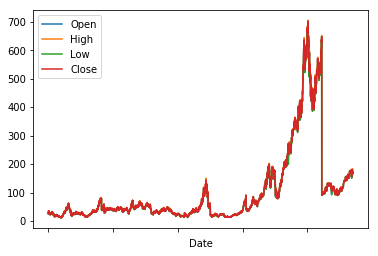

In [4]:
data[['Open', 'High', 'Low', 'Close']].plot()

In [6]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

X, y = split_sequences(data[['Open', 'High', 'Low', 'Close']].values, 5)

In [7]:
X.shape, y.shape

((9395, 5, 4), (9395, 4))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [10]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

model = Sequential([LSTM(128, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
                    LSTM(64, activation='relu'), 
                    Dense(y.shape[1], activation="linear")])
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 128)            68096     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 117,764
Trainable params: 117,764
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.1)

Train on 6764 samples, validate on 752 samples
Epoch 1/50
6764/6764 [==============================] - 4s 657us/step - loss: 885.7269 - val_loss: 89.0375
Epoch 2/50
6764/6764 [==============================] - 2s 239us/step - loss: 9.6403 - val_loss: 130.3319
Epoch 3/50
6764/6764 [==============================] - 2s 259us/step - loss: 6.1398 - val_loss: 44.4658
Epoch 4/50
6764/6764 [==============================] - 2s 223us/step - loss: 5.1364 - val_loss: 41.5661
Epoch 5/50
6764/6764 [==============================] - 2s 226us/step - loss: 4.7416 - val_loss: 39.0082
Epoch 6/50
6764/6764 [==============================] - 2s 223us/step - loss: 4.2271 - val_loss: 34.9406
Epoch 7/50
6764/6764 [==============================] - 1s 221us/step - loss: 3.8209 - val_loss: 34.6542
Epoch 8/50
6764/6764 [==============================] - 2s 225us/step - loss: 3.9536 - val_loss: 30.7243
Epoch 9/50
6764/6764 [==============================] - 2s 224us/step - loss: 4.0193 - val_loss: 25.3121
Epoch

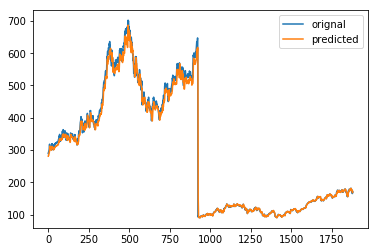

In [25]:
pd.DataFrame({"orignal":y_test[:,-1], "predicted":model.predict(X_test)[:,-1]}).plot()
# model.predict(X).reshape(-1,).shape
# y_test[:,-1].shape
# model.predict(X_test)[:,-1].shape

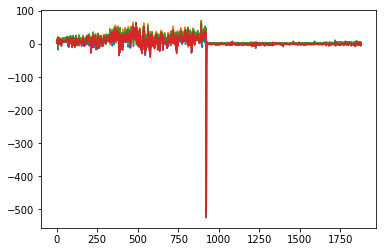

In [27]:
plt.plot(y_test-model.predict(X_test))

In [78]:
# np.hstack((y_train, y_test)).shape
np.vstack((X_train,X_test)).shape

(9396, 5, 3)